## 분류 문제 - 보충

In [14]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

In [2]:
from sklearn.model_selection import GridSearchCV, KFold, cross_validate

In [3]:
import pandas as pd
import numpy as np

In [4]:
import matplotlib.pyplot as plt

### 데이터 불러오기

In [5]:
titanic = pd.read_csv('Titanic.csv', engine = 'python')
titanic.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived
0,3,male,22.0,1,0,7.2500,S,0
1,1,female,38.0,1,0,71.2833,C,1
2,3,female,26.0,0,0,7.9250,S,1
3,1,female,35.0,1,0,53.1000,S,1
4,3,male,35.0,0,0,8.0500,S,0


In [6]:
titanic['Embarked'] = titanic['Embarked'].map({'S':1, 'C':2, 'Q':3})

In [7]:
titanic['Sex'] = titanic['Sex'].map({'male':1, 'female':0})

In [8]:
# X, y를 나누겠습니다.
X, y = titanic[titanic.columns.drop('Survived')], titanic['Survived']

In [9]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 889 entries, 0 to 888
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    889 non-null    int64  
 1   Sex       889 non-null    int64  
 2   Age       889 non-null    float64
 3   SibSp     889 non-null    int64  
 4   Parch     889 non-null    int64  
 5   Fare      889 non-null    float64
 6   Embarked  889 non-null    int64  
dtypes: float64(2), int64(5)
memory usage: 48.7 KB


### (1) Tree model visualization 

In [11]:
clf = DecisionTreeClassifier()

In [12]:
clf.fit(X,y)

DecisionTreeClassifier()

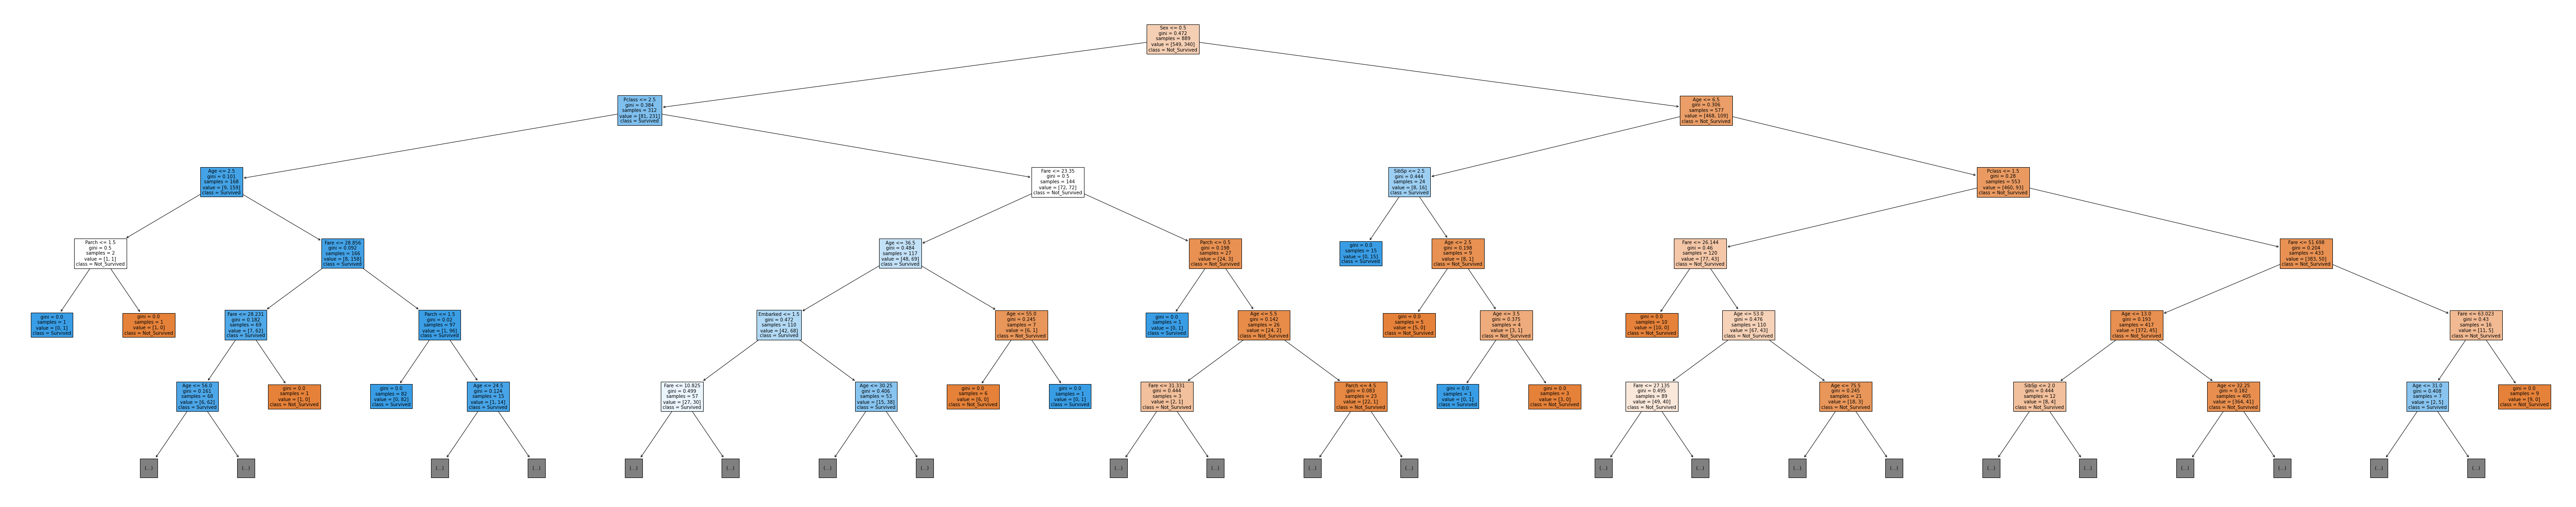

In [15]:
fig, axes = plt.subplots(1,1, figsize = (100,20))
tree.plot_tree(clf, feature_names = X.columns,filled = True,class_names= ['Not_Survived','Survived'] , ax = axes, max_depth= 5,  fontsize=10)
# filled = paint nodes to indicate majority class for classification, 


plt.show()
# column 명
# gini (impurity)
# samples : 샘플수
# value: current node에서 왼쪽, 오른쪽 (childe node)로 가는 샘플 수

In [16]:
# 학습한 tree의 
# max-depth, node 수를 DecisionTreeClassifier object 아래 .tree_ 에서 확인할
# 수 있습니다.

# max_depth
print(f'학습된 tree 의 max_depth: {clf.tree_.max_depth}')

# node_count
print(f'학습된 tree 의 총 노드 수: {clf.tree_.node_count}')

# the number of leaves of the decision tree.
print(f'학습된 tree 의 총 leave 수: {clf.tree_.n_leaves}')

학습된 tree 의 max_depth: 21
학습된 tree 의 총 노드 수: 409
학습된 tree 의 총 leave 수: 205


In [17]:
clf.tree_.node_count

409

### (2) max_depth 가 20 이라는 점을 고려해서 max_depth의 parameter를 3 ~ 20 사이에서 최적값을 구해보겠습니다.

In [19]:
# param_grid 설정
param_grid = {'max_depth':np.arange(5,21)}

# estimator 설정
estimator = DecisionTreeClassifier()

gscv = GridSearchCV(estimator, param_grid, cv= 5)
gscv.fit(X, y)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20])})

In [20]:
# best params
gscv.best_params_

{'max_depth': 8}

In [21]:
# best estimator
gscv.best_estimator_

DecisionTreeClassifier(max_depth=8)

In [22]:
# cv_resutls
gscv.cv_results_

{'mean_fit_time': array([0.00389614, 0.01680179, 0.00284948, 0.00282784, 0.00291352,
        0.00296607, 0.00297036, 0.00305185, 0.00306468, 0.00307307,
        0.00306191, 0.00305905, 0.00307622, 0.00304017, 0.00306177,
        0.00305376]),
 'std_fit_time': array([5.72408314e-04, 2.66052994e-02, 3.82926068e-05, 1.11496315e-05,
        4.70673300e-05, 2.71879150e-05, 4.16826596e-05, 1.33604632e-05,
        1.21751384e-05, 2.44699710e-05, 2.34202297e-05, 4.31722264e-05,
        1.92801485e-05, 1.48583560e-05, 4.91107551e-05, 4.62415523e-05]),
 'mean_score_time': array([0.00218549, 0.00196438, 0.00160384, 0.00156398, 0.00157447,
        0.00158486, 0.00156536, 0.00159311, 0.00158849, 0.00156612,
        0.00154943, 0.00154991, 0.00154347, 0.0015183 , 0.00154824,
        0.00151458]),
 'std_score_time': array([7.59405056e-05, 1.45177096e-04, 4.51058715e-05, 2.30955623e-05,
        2.54933574e-05, 2.80960287e-05, 2.42374972e-05, 7.59354753e-06,
        1.16416645e-05, 8.09697015e-06, 2.46

### (3) Post pruning (사후 가지치기) 을 하는 방법에 대해 알아보겠습니다.

ccp_alpha 값이 클수록 pruning되는 노드 수가 증가합니다.     
본 실습에서는 트리 정규화에 대한 ccp_alpha 의 효과 와 cross validation에 따라 ccp_alpha를 선택하는 실습을 진행하겠습니다.

In [31]:
# train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size= 0.3)

In [32]:
clf = DecisionTreeClassifier()
clf.fit(X_train,y_train)
path = clf.cost_complexity_pruning_path(X, y)
# Compute the pruning path during Minimal Cost-Complexity Pruning.
ccp_alphas, impurities = path.ccp_alphas, path.impurities

In [33]:
path

{'ccp_alphas': array([0.00000000e+00, 2.04519890e-05, 3.12460942e-05, 4.54488643e-05,
        5.45386372e-05, 6.23298711e-05, 6.39124655e-05, 9.47775098e-05,
        1.87476565e-04, 2.24971879e-04, 2.59582937e-04, 3.11499524e-04,
        3.37457818e-04, 3.52228699e-04, 3.60803956e-04, 3.74953131e-04,
        3.74953131e-04, 3.74953131e-04, 3.74953131e-04, 5.45386372e-04,
        5.59930009e-04, 5.71357152e-04, 6.90254627e-04, 6.99912511e-04,
        7.42175269e-04, 7.49906262e-04, 7.49906262e-04, 8.08827468e-04,
        8.43644544e-04, 8.49893763e-04, 8.67748674e-04, 8.67748674e-04,
        8.74890639e-04, 8.99887514e-04, 8.99887514e-04, 8.99887514e-04,
        9.37382827e-04, 9.50811535e-04, 9.51804101e-04, 9.58350601e-04,
        9.64165194e-04, 9.74878140e-04, 9.84102862e-04, 9.99875016e-04,
        1.00097782e-03, 1.00872131e-03, 1.03833175e-03, 1.05455568e-03,
        1.06058171e-03, 1.06236720e-03, 1.12485939e-03, 1.16803763e-03,
        1.16812322e-03, 1.24394614e-03, 1.30892729

In [34]:
ccp_alphas

array([0.00000000e+00, 2.04519890e-05, 3.12460942e-05, 4.54488643e-05,
       5.45386372e-05, 6.23298711e-05, 6.39124655e-05, 9.47775098e-05,
       1.87476565e-04, 2.24971879e-04, 2.59582937e-04, 3.11499524e-04,
       3.37457818e-04, 3.52228699e-04, 3.60803956e-04, 3.74953131e-04,
       3.74953131e-04, 3.74953131e-04, 3.74953131e-04, 5.45386372e-04,
       5.59930009e-04, 5.71357152e-04, 6.90254627e-04, 6.99912511e-04,
       7.42175269e-04, 7.49906262e-04, 7.49906262e-04, 8.08827468e-04,
       8.43644544e-04, 8.49893763e-04, 8.67748674e-04, 8.67748674e-04,
       8.74890639e-04, 8.99887514e-04, 8.99887514e-04, 8.99887514e-04,
       9.37382827e-04, 9.50811535e-04, 9.51804101e-04, 9.58350601e-04,
       9.64165194e-04, 9.74878140e-04, 9.84102862e-04, 9.99875016e-04,
       1.00097782e-03, 1.00872131e-03, 1.03833175e-03, 1.05455568e-03,
       1.06058171e-03, 1.06236720e-03, 1.12485939e-03, 1.16803763e-03,
       1.16812322e-03, 1.24394614e-03, 1.30892729e-03, 1.32069683e-03,
      

In [35]:
impurities

array([0.02448176, 0.02450221, 0.02453346, 0.02457891, 0.02463345,
       0.02469578, 0.02475969, 0.02494924, 0.02513672, 0.02558666,
       0.02610583, 0.02766333, 0.02833824, 0.02939493, 0.03047734,
       0.03085229, 0.03122725, 0.0316022 , 0.03197715, 0.03252254,
       0.03532219, 0.03703626, 0.03979728, 0.04189702, 0.04412354,
       0.04562336, 0.04637326, 0.0504174 , 0.05210469, 0.05380448,
       0.05814322, 0.05901097, 0.06251053, 0.06431031, 0.06611008,
       0.06700997, 0.06888473, 0.0745896 , 0.07839682, 0.08031352,
       0.08224185, 0.08614136, 0.09007778, 0.09207753, 0.10008535,
       0.10412023, 0.10827356, 0.11249178, 0.11461295, 0.11780005,
       0.11892491, 0.12242902, 0.12359714, 0.12732898, 0.12863791,
       0.12995861, 0.13529   , 0.13675528, 0.14995697, 0.15145678,
       0.15445641, 0.16048442, 0.16361251, 0.16682639, 0.17182577,
       0.18032471, 0.1820602 , 0.18390613, 0.18578089, 0.18954546,
       0.19147379, 0.19355046, 0.20510099, 0.21329865, 0.21891

In [36]:
clf.tree_.max_depth

18

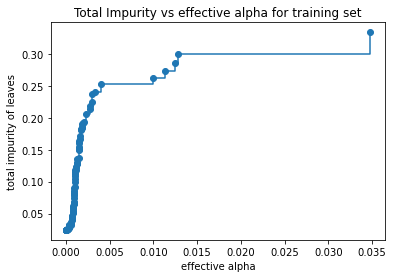

In [37]:
# In the following plot, 
# the maximum effective alpha value is removed, 
# because it is the trivial tree with only one node.
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
# drawstyle --> step function.

ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")
plt.show()

In [38]:
# Next, we train a decision tree using the effective alphas. 
# The last value in ccp_alphas is the alpha value that prunes the whole tree,
# leaving the tree, clfs[-1], with one node.
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)
print(
    "Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
        clfs[-1].tree_.node_count, ccp_alphas[-1]
    )
)

Number of nodes in the last tree is: 1 with ccp_alpha: 0.13855137961834213


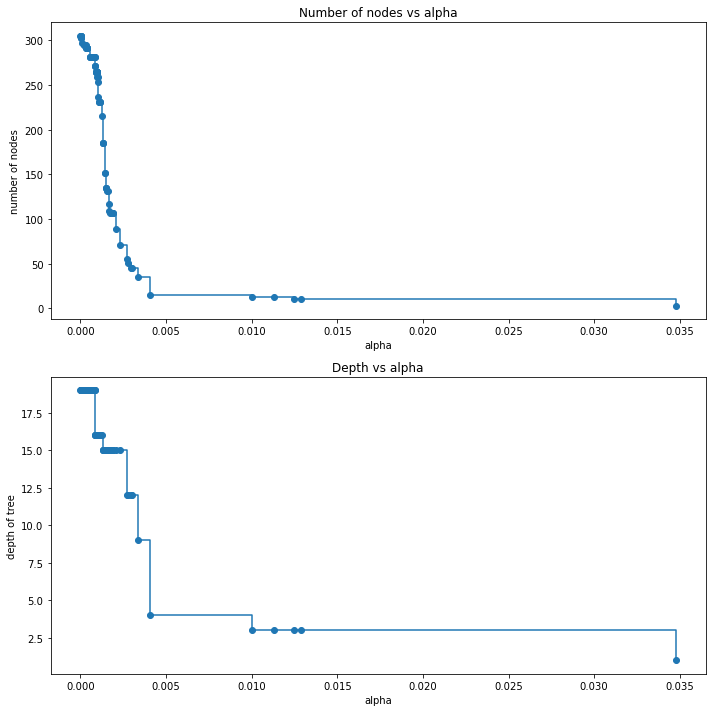

In [39]:
# For the remainder of this example,
# we remove the last element in clfs and ccp_alphas,
# because it is the trivial tree with only one node.
# Here we show that the number of nodes and tree depth decreases as alpha increases.
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1, figsize= (10,10))
ax[0].plot(ccp_alphas, node_counts, marker="o", drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")

ax[1].plot(ccp_alphas, depth, marker="o", drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")

fig.tight_layout()

In [40]:
# When ccp_alpha is set to zero and keeping the other default parameters of DecisionTreeClassifier,.
# As alpha increases, more of the tree is pruned, 
# thus creating a decision tree that generalizes better.
# In this example, setting ccp_alpha=0.0027 maximizes the testing accuracy.

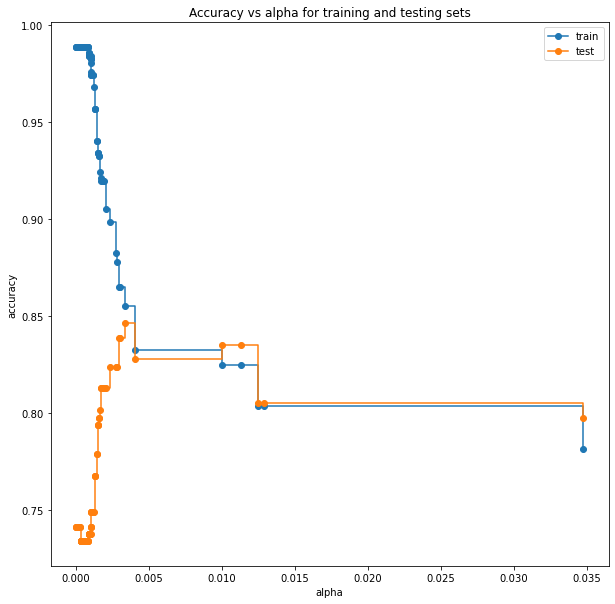

In [41]:
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

fig, ax = plt.subplots(figsize= (10,10))
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()

In [42]:
ccp_alphas[np.argmax(test_scores)]

0.003345136303516502